# Sentiment Analysis: Customer Feedback

# Notebook 7.1: SVM Model

In this notebook, customer feedback/comments/reviews are analyzed to determine whether they are positive, negative, or neutral using the Support Vector Machine (SVM) model.

## Setup

In [1]:
import os

# libraries to work with data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# libraries for machine learning
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

# libraries for saving/loading models
import joblib
import pickle

## Loading Clean Datasets

In [2]:
df_train = pd.read_pickle('./datasets/final_training_dataset.pkl')
df_train

,review_text,sentiment
0,wow love place,1
1,crust not good,0
2,not tasti textur nasti,0
3,stop late may bank holiday rick steve recommen...,1
4,select menu great price,1
...,...,...
25895,disappoint qualiti,0
25896,amaz experi highli recommend,1
25897,fast deliveri great packag,1
25898,great valu money,1


In [3]:
df_test = pd.read_pickle('./datasets/final_testing_dataset.pkl')
df_test

,review_text,sentiment
0,fantast spot even quit cocktail swell host yel...,1
1,love love love calamari good spici endless lis...,1
2,love place stiff martini cocktail cheap drink ...,1
3,everyth great cocktail bar great locat ambianc...,1
4,come pirat game around 530ish even get lucki t...,1
...,...,...
4316,wife catch show golden nugget hear good thing ...,0
4317,dumb show ever seen never laugh minut realiz w...,0
4318,girlfriend go show absolut terriblenot funni n...,0
4319,restroom look like bombard improvis shack amid...,0


## SVM: Data Splitting

The training dataset is split into features (X) and target (y). Each of these is further divided into a training set (X_train, y_train) and a validation set (X_val, y_val) to evaluate the model's generalization ability. A separate test set (X_test, y_test) is kept aside and does not need further division.

The **labels (y)** in the training, validation, and test datasets **should be integers** for multi-class classification.

In [4]:
# features and labels for the training dataset
X = df_train['review_text'].values  # raw text, not vectorized # np array
y = df_train['sentiment'].values.astype(int)  # convert to integers

# split the training dataset into validation dataset
raw_X_train, raw_X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# features and labels for the testing dataset
raw_X_test = df_test['review_text'].values  # raw text, not vectorized # np array
y_test = df_test['sentiment'].values.astype(int)  # convert to integers

# check the shape and data type of the datasets before and after splitting
elements = {
    "X": X,
    "raw_X_train": raw_X_train,
    "raw_X_val": raw_X_val,
    "raw_X_test": raw_X_test,
    "y": y,
    "y_train": y_train,
    "y_val": y_val,
    "y_test": y_test
}

for name, element in elements.items():
    print(f"{name} shape: {element.shape}")
    print(f"{name} data type: {element.dtype}\n")

X shape: (25900,)
X data type: object

raw_X_train shape: (20720,)
raw_X_train data type: object

raw_X_val shape: (5180,)
raw_X_val data type: object

raw_X_test shape: (4321,)
raw_X_test data type: object

y shape: (25900,)
y data type: int64

y_train shape: (20720,)
y_train data type: int64

y_val shape: (5180,)
y_val data type: int64

y_test shape: (4321,)
y_test data type: int64



After splitting the dataset, the class distributions for the training and validation datasets should be similar since they come from the same dataset. The test dataset, however, can have a different distribution as it comes from a completely separate dataset, which is acceptable in real-world scenarios.

In [5]:
# get distributions
train_dist = Counter(y_train)
val_dist = Counter(y_val)
test_dist = Counter(y_test)

# calculate totals
train_total = len(y_train)
val_total = len(y_val)
test_total = len(y_test)

# print to compare distributions with percentages
print("training dataset label distribution:")
for label, count in sorted(train_dist.items()):
    percentage = (count / train_total) * 100
    print(f"  (Class {label}): {count} ({percentage:.2f}%)")
print(f"  Total: {train_total:,}")

print("\nvalidation dataset label distribution:")
for label, count in sorted(val_dist.items()):
    percentage = (count / val_total) * 100
    print(f"  (Class {label}): {count} ({percentage:.2f}%)")
print(f"  Total: {val_total:,}")

print("\ntesting dataset label distribution:")
for label, count in sorted(test_dist.items()):
    percentage = (count / test_total) * 100
    print(f"  (Class {label}): {count} ({percentage:.2f}%)")
print(f"  Total: {test_total:,}")

training dataset label distribution:
  (Class 0): 8271 (39.92%)
  (Class 1): 8369 (40.39%)
  (Class 2): 4080 (19.69%)
  Total: 20,720

validation dataset label distribution:
  (Class 0): 2070 (39.96%)
  (Class 1): 2105 (40.64%)
  (Class 2): 1005 (19.40%)
  Total: 5,180

testing dataset label distribution:
  (Class 0): 1332 (30.83%)
  (Class 1): 2989 (69.17%)
  Total: 4,321


## SVM: Encoding

For sentiment analysis, TF-IDF is well-suited for SVM because it reduces the impact of very frequent but uninformative words (such as "the", "is") and highlights sentiment-bearing terms (like "bad", "excellent"). TF-IDF provides better feature scaling and normalization, which aligns well with SVM's optimization process and helps the model find better decision boundaries.

***

The `TfidfVectorizer` is a text feature extraction method from the `scikit-learn` library. It is used to **transform a collection of review texts into a TF-IDF (Term Frequency-Inverse Document Frequency) weighted model**, represented as a sparse matrix. The process is as follows:
- `fit()`: Learns the vocabulary from the training data and calculates the inverse document frequency (IDF) weights (does not create a matrix yet).
- `transform()`: Encodes text into a TF-IDF weighted model, represented as a sparse matrix.
- `fit_transform()`: Combines both steps.

***

Each row of the matrix corresponds to a review, and each column corresponds to a unique word (or n-gram) in the entire collection of reviews. The **value at each position represents the TF-IDF score** of that word in the review, which is calculated as the product of:
- **Term Frequency (TF)**: How often the word appears in the review (normalized by review length).
- **Inverse Document Frequency (IDF)**: How rare or common the word is across all reviews (logarithmically scaled).

This scoring mechanism means that words that appear frequently in a specific review but rarely across all reviews receive higher TF-IDF scores, making them more distinctive and informative for classification.

Example: Given a review "this is is not good":
- "this is is not good" &#8594; {this: 0.23, is: 0.45, not: 0.31, good: 0.52} &#8594; [0.23, 0.45, 0.31, 0.52]
  - Higher scores indicate more distinctive words (e.g., "good" = 0.52, "not" = 0.31)
  - Lower scores indicate less distinctive or more common words (e.g., "this" = 0.23, "is" = 0.45, but "is" appears twice so it gets a higher TF component)
- row: "this is is not good"
- column: [0.23, 0.45, 0.31, 0.52] (where position 0=this, position 1=is, position 2=not, position 3=good)

***

It **does not perform padding** as it only creates <u>fixed-size</u> feature vectors <u>(not sequences)</u> for each review. The length of these vectors is determined by the total number of unique words (or n-grams) across all reviews (i.e., the vocabulary). The number of features can be controlled by setting the `max_features` parameter.

Example: If `max_features = 3`, the method will only consider the 3 most important words in the corpus for TF-IDF calculation.
- "this is not good" &#8594; {good: 0.52, is: 0.45, not: 0.31} &#8594; {is: 0.45, not: 0.31, good: 0.52} &#8594; [0.45, 0.31, 0.52]

Any word not in the top `max_features` vocabulary is ignored everywhere, no matter where it appears in a review.

***

Since it only **calculates TF-IDF scores for words** in each review and **ignores their order**, different word sequences that contain the same words will produce identical feature vectors (assuming the same TF-IDF scores).

Example:
- "this is not good" &#8594; {this: 0.23, is: 0.45, not: 0.31, good: 0.52} &#8594; [0.23, 0.45, 0.31, 0.52]
- "this good is not" &#8594; {this: 0.23, is: 0.45, not: 0.31, good: 0.52} &#8594; [0.23, 0.45, 0.31, 0.52]

However, it **can capture local word order** by using n-grams (e.g., bigrams), allowing it to distinguish phrases such as "not good" from "good not".

***

It takes these parameters:

- `max_features`: Limits the vocabulary to the top N words (or n-grams) by document frequency, reducing dimensionality and focusing on the most informative terms. `max_features=None` uses all words.
- `ngram_range`: Specifies the n-gram sizes to extract _(min_n, max_n)_.
> Example: `ngram_range = (1, 2)` captures unigrams and bigrams:
> - "this is not good" &#8594; ["this", "is", "not", "good", "this is", "is not", "not good"]
- `min_df`: Removes very rare words (by minimum document count or proportion), which are often noise or typos and add little useful information.
- `max_df`: Removes very common words (by maximum document count or proportion), which usually carry little discriminative power for classification.

In [6]:
# load TfidfVectorizer
with open('./text_transformers/tfidf_vectorizer.pkl', 'rb') as f:
    tfidf = pickle.load(f)

# training data: only transform (already fitted before)
X_train = tfidf.transform(raw_X_train)

# validation data: only transform (using vocabulary from training)
X_val = tfidf.transform(raw_X_val)

print(f"train matrix dimensions: {X_train.shape}")
print(f"val matrix dimensions: {X_val.shape}")

train matrix dimensions: (20720, 790)
val matrix dimensions: (5180, 790)


## SVM: Model Configuration

The `inspect.signature()` method checks the available parameters that can be passed to the `SVC` constructor. This is useful for verifying which hyperparameters are supported by the current version of scikit-learn and understanding the model's configuration options before training.

***

The model takes these hyperparameters:

- `kernel`: The kernel function determines how the SVM transforms the input data to find a decision boundary. It can be set to:
    - _linear_: Uses a linear kernel (dot product). Fast and efficient, works well for high-dimensional data like text. Best when classes are linearly separable.
    $$K(x_i, x_j) = x_i^T x_j$$
    - _rbf_ (Radial Basis Function): Uses a Gaussian kernel. Can capture non-linear patterns and complex decision boundaries. Good for non-linearly separable data.
    $$K(x_i, x_j) = \exp(-\gamma ||x_i - x_j||^2)$$
    - _poly_ (Polynomial): Uses a polynomial kernel. Can model polynomial relationships.
    $$K(x_i, x_j) = (\gamma x_i^T x_j + r)^degree$$
    - _sigmoid_: Uses a sigmoid kernel. Less commonly used, similar to neural network activation.
    $$K(x_i, x_j) = \tanh(\gamma x_i^T x_j + r)$$
    
    > For text classification with TF-IDF features, **linear kernel** is often preferred because:
    > - Text data is typically high-dimensional and sparse
    > - Linear SVMs are faster to train and evaluate
    > - Linear kernels often perform as well as non-linear kernels for text
    > - However, **RBF kernel** can sometimes capture subtle non-linear patterns and may improve performance

***

- `C`: The regularization parameter that controls the trade-off between maximizing the margin and minimizing classification errors. It is the inverse of regularization strength.
    - $C = 0.1$ → stronger regularization (wider margin, simpler model, less overfitting, but may underfit)
    - $C = 1.0$ → moderate regularization (baseline, good starting point)
    - $C = 10.0$ → weaker regularization (narrower margin, more complex model, may overfit)

***

- `gamma`: Kernel coefficient for 'rbf', 'poly', and 'sigmoid' kernels. It defines how far the influence of a single training example reaches.
    - _scale_ (default): Uses $1 / (n\_features \times X.var())$ as value of gamma
    - _auto_: Uses $1 / n\_features$ as value of gamma
    - _float_: Manual specification. Larger values make the model more sensitive to individual points (may overfit), smaller values make it smoother (may underfit)
    - Only relevant for non-linear kernels (rbf, poly, sigmoid)

***

- `class_weight`: It determines the weight of each class during training, typically inversely proportional to class frequencies. It helps handle class imbalance by penalizing misclassification of rare classes more heavily. It can be set to:
    - _None_: No weighting; all classes are treated equally (default).
    - _balanced_: Automatically adjusts weights inversely proportional to class frequencies in the training data.
    - _dict_: A dictionary mapping class labels to weights, e.g., {0: 1.0, 1: 5.0} for manual control.

    Without balanced weights, the model might bias predictions toward the majority classes, leading to poor performance on the minority class.

***

- `degree`: Degree of the polynomial kernel function ('poly'). Ignored by all other kernels. Default is 3.
- `coef0`: Independent term in kernel function. Only significant in 'poly' and 'sigmoid' kernels. Default is 0.0.
- `max_iter`: The maximum number of iterations for the solver to converge. Default is -1 (no limit).
- `probability`: Whether to enable probability estimates. If `True`, enables `predict_proba()` method. Uses cross-validation internally, which makes training slower. Default is `False`.

In [7]:
import inspect

# check what parameters LogisticRegression accepts (optional)
params = inspect.signature(SVC.__init__).parameters
print("Available parameters:", list(params.keys()))

Available parameters: ['self', 'C', 'kernel', 'degree', 'gamma', 'coef0', 'shrinking', 'probability', 'tol', 'cache_size', 'class_weight', 'verbose', 'max_iter', 'decision_function_shape', 'break_ties', 'random_state']


In [8]:
# build the model
model = SVC(
    kernel='linear',  # linear is fast and often best for text  # SVM needs kernel, not solver
    random_state=42,
    C=1.0,            # regularization parameter
    class_weight='balanced',
    probability=True  # enable predict_proba()
)

In [9]:
# create a pipeline with vectorizer and model
pipeline = Pipeline([
    ('tfidf', tfidf),
    ('svm', model)
])

## SVM: Model Training

Since the pipeline handles vectorization, only raw text is passed.

In [10]:
pipeline.fit(raw_X_train, y_train)  # use raw text, not vectorized

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('svm', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


## SVM: Model Evaluation

The baseline model, that uses default values for hyperparameters, is evaluated on the validation dataset.

In [11]:
# evaluate on validation dataset using the baseline model
y_val_pred = pipeline.predict(raw_X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

print(f"accuracy on validation data with the baseline model: {val_accuracy:.4f}")
print(f"F1-score on validation data with the baseline model: {val_f1:.4f}")

accuracy on validation data with the baseline model: 0.9927
F1-score on validation data with the baseline model: 0.9927


## SVM: Hyperparameter Tuning

The current baseline model may be improved further by finding optimal hyperparameters through tuning. This optimization can be measured using evaluation metrics such as accuracy score or F1-score.

Since the classes are imbalanced (with Neutral class having approximately half the samples of Positive and Negative classes), the **F1-macro score should be used as the primary evaluation measure**, as it provides a better assessment of model performance across all classes compared to accuracy alone, ensuring that the minority class (Neutral) is not ignored during hyperparameter optimization.

In [12]:
# check actual vocabulary size
vocab_size = len(tfidf.vocabulary_)
print(f"total number of unique features/words in the training data: {vocab_size}")

total number of unique features/words in the training data: 790


The total number of unique features/words (vocabulary size) in the training data is computed first to establish an upper bound for the hyperparameter range. Since it is less than 1000, `max_features` is not tuned here, as the vocabulary size is already manageable and further reduction may not provide significant benefits.

The hyperparameters to tune are:
- `C` for `SVC` object: The range `[0.1, 1.0, 10.0]` is tested to find the optimal balance between model complexity and generalization.
- `kernel` for `SVC` object: Both `linear` and `rbf` kernels are tested to determine which kernel function best captures the patterns in the text data.

In [13]:
# define parameter grid
param_grid = {
    'svm__C': [0.1, 1.0, 10.0],  # regularization strength
    'svm__kernel': ['linear', 'rbf'],  # 'rbf' kernel is slower but can capture non-linear patterns
}

# create GridSearchCV object
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,  # 3-fold cross-validation
    scoring={'f1_macro': 'f1_macro', 'accuracy': 'accuracy'},
    refit='f1_macro',  # refits best model automatically using the best params chosen by 'f1_macro'
    n_jobs=-1,
    verbose=1
)

In [14]:
# start hyperparameter tuning
grid_search.fit(raw_X_train, y_train)  # use raw text, not vectorized

Fitting 3 folds for each of 6 candidates, totalling 18 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'svm__C': [0.1, 1.0, ...], 'svm__kernel': ['linear', 'rbf']}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.","{'accuracy': 'accuracy', 'f1_macro': 'f1_macro'}"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",'f1_macro'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate

In [15]:
# get detailed results (optional)
results_df = pd.DataFrame(grid_search.cv_results_).sort_values('mean_test_f1_macro', ascending=False)
results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svm__C,param_svm__kernel,params,split0_test_f1_macro,split1_test_f1_macro,split2_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
5,7.809010,0.620113,0.377264,0.100232,10.0,rbf,"{'svm__C': 10.0, 'svm__kernel': 'rbf'}",0.994591,0.993510,0.993388,0.993830,0.000541,1,0.993485,0.992182,0.992036,0.992568,0.000651,1
3,16.564418,0.302822,0.688066,0.157952,1.0,rbf,"{'svm__C': 1.0, 'svm__kernel': 'rbf'}",0.994832,0.993269,0.993388,0.993830,0.000710,2,0.993774,0.991892,0.992036,0.992568,0.000855,1
4,7.158521,0.578774,0.350483,0.011241,10.0,linear,"{'svm__C': 10.0, 'svm__kernel': 'linear'}",0.994351,0.992548,0.992547,0.993149,0.000850,3,0.993195,0.991024,0.991022,0.991747,0.001024,3
2,10.101320,0.718908,0.457331,0.036424,1.0,linear,"{'svm__C': 1.0, 'svm__kernel': 'linear'}",0.994351,0.992067,0.992547,0.992988,0.000983,4,0.993195,0.990444,0.991022,0.991554,0.001184,4
0,16.385610,0.886698,0.762835,0.045075,0.1,linear,"{'svm__C': 0.1, 'svm__kernel': 'linear'}",0.990021,0.988874,0.988149,0.989015,0.000771,5,0.987983,0.986680,0.985809,0.986824,0.000893,5


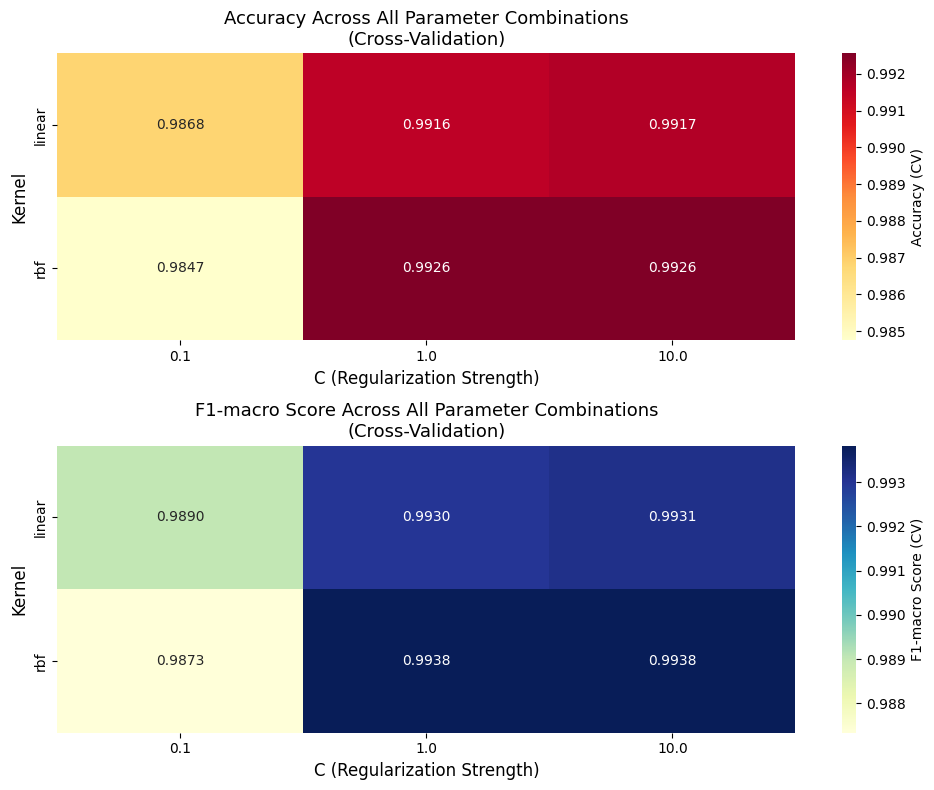

In [16]:
# (optional)
# create matrices for heatmaps
f1_matrix = np.zeros((len(param_grid['svm__kernel']), len(param_grid['svm__C'])))
acc_matrix = np.zeros((len(param_grid['svm__kernel']), len(param_grid['svm__C'])))

for idx, row in results_df.iterrows():
    kernel_value = row['param_svm__kernel']
    C_value = row['param_svm__C']
    
    i = param_grid['svm__kernel'].index(kernel_value)
    j = param_grid['svm__C'].index(C_value)
    
    # get scores from dataframe
    f1_matrix[i, j] = row['mean_test_f1_macro']
    acc_matrix[i, j] = row['mean_test_accuracy']

# create heatmaps
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# plot accuracy heatmap
sns.heatmap(acc_matrix, annot=True, fmt='.4f', cmap='YlOrRd',
            xticklabels=param_grid['svm__C'],  # Fixed: use svm__C instead of logr__C
            yticklabels=param_grid['svm__kernel'],  # Fixed: use kernel values instead of 'Accuracy'
            ax=ax1, cbar_kws={'label': 'Accuracy (CV)'})
ax1.set_xlabel('C (Regularization Strength)', fontsize=12)
ax1.set_ylabel('Kernel', fontsize=12)  # Fixed: label as 'Kernel'
ax1.set_title('Accuracy Across All Parameter Combinations\n(Cross-Validation)', fontsize=13)

# plot F1-macro heatmap
sns.heatmap(f1_matrix, annot=True, fmt='.4f', cmap='YlGnBu',
            xticklabels=param_grid['svm__C'],  # Fixed: use svm__C instead of logr__C
            yticklabels=param_grid['svm__kernel'],  # Fixed: use kernel values instead of 'F1-macro'
            ax=ax2, cbar_kws={'label': 'F1-macro Score (CV)'})
ax2.set_xlabel('C (Regularization Strength)', fontsize=12)
ax2.set_ylabel('Kernel', fontsize=12)  # Fixed: label as 'Kernel'
ax2.set_title('F1-macro Score Across All Parameter Combinations\n(Cross-Validation)', fontsize=13)

plt.tight_layout()
plt.show()

In [17]:
# get results
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# select the best model
best_pipeline = grid_search.best_estimator_

# evaluate accuracy on validation dataset using the best model
val_accuracy = best_pipeline.score(raw_X_val, y_val)  # use raw text, not vectorized
print(f"accuracy on validation data with the best model: {val_accuracy:.6f}")

Best parameters: {'svm__C': 10.0, 'svm__kernel': 'rbf'}
Best cross-validation score: 0.9938
accuracy on validation data with the best model: 0.994015


## SVM: Model Testing

After fine-tuning the hyperparameters, the model is evaluated using the testing dataset.

In [18]:
## actual labels
class_names = []

## get unique classes (integers)
classes = sorted(df_train['sentiment'].unique())

## map integers to actual labels
for c in classes:
    if c == 0:
        class_names.append("Negative")
    elif c == 1:
        class_names.append("Positive")
    elif c == 2:
        class_names.append("Neutral")

print(f"class names: {class_names}")

class names: ['Negative', 'Positive', 'Neutral']


In [19]:
# transform test data
X_test = tfidf.transform(raw_X_test)

# predictions
y_test_pred = best_pipeline.predict(raw_X_test)

# evaluation metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
test_f1_weighted = f1_score(y_test, y_test_pred, average='weighted')

print(f"Test Accuracy: {test_accuracy:.6f}")
print(f"Test F1-macro: {test_f1_macro:.6f}")
print(f"Test F1-weighted: {test_f1_weighted:.6f}")

# classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, labels=[0, 1, 2], 
                          target_names=class_names, zero_division=0))

Test Accuracy: 0.788938
Test F1-macro: 0.777810
Test F1-weighted: 0.796878

Classification Report:
              precision    recall  f1-score   support

    Negative       0.60      0.92      0.73      1332
    Positive       0.95      0.73      0.83      2989
     Neutral       0.00      0.00      0.00         0

    accuracy                           0.79      4321
   macro avg       0.52      0.55      0.52      4321
weighted avg       0.84      0.79      0.80      4321



## SVM: Confusion Matrix

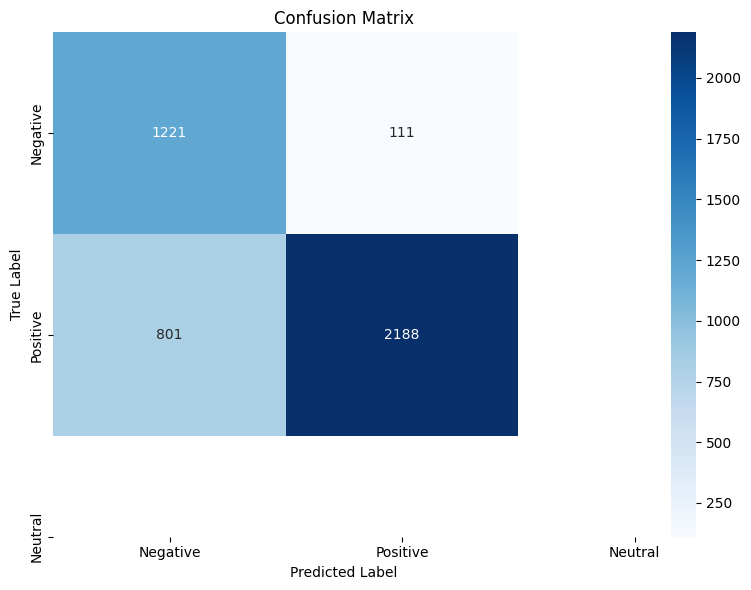

In [20]:
# compute a confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

Overall, the model demonstrates strong generalization on unseen data, with consistently high performance across evaluation metrics. The confusion matrix shows that the model is particularly effective at identifying positive instances, while performance on the negative class is comparatively weaker, indicating a mild prediction bias toward the positive label.

##  SVM: Model Testing with Any Reviews

In [21]:
review_to_predict = str(input("Enter a review: "))
prediction = best_pipeline.predict([review_to_predict])[0]
prediction_probs = best_pipeline.predict_proba([review_to_predict])[0]

if prediction == 0:
    print(f"\nPrediction: {class_names[0]}")
elif prediction == 1:
    print(f"\nPrediction: {class_names[1]}")
elif prediction == 2:
    print(f"\nPrediction: {class_names[2]}")

print(f"\nProbabilities: {class_names[0]}: {prediction_probs[0]:.4f}, "
          f"{class_names[1]}: {prediction_probs[1]:.4f}, "
          f"{class_names[2]}: {prediction_probs[2]:.4f}")

Enter a review: I recommend this to anyone who is looking for a delicious meal

Prediction: Negative

Probabilities: Negative: 0.9925, Positive: 0.0075, Neutral: 0.0001


## SVM: Saving Model

In [22]:
os.makedirs('./models', exist_ok=True)
joblib.dump(best_pipeline, './models/sentiment_analysis_svm_model.joblib')

['./models/sentiment_analysis_svm_model.joblib']

This notebook is done by `La Wun Nannda`.